In [1]:
include("../src/vafdyn.jl")
using .VAFDyn
using OrdinaryDiffEq, Distances, Distributions
using JLD2
using ApproxBayes

In [22]:
using Plots
gr()

Plots.GRBackend()

In [3]:
# create reference measurement:
paramsTrue = Dict(
    "N"=>1100,
    "ρ"=>1.0,
    "ϕ"=>3.0,
    "μ"=>4.2
)
evolveTime = 59
sampleSize = 89

function mutBurdenStats(params, evolveTime)
    ρ = params["ρ"]
    ϕ = params["ϕ"]
    λ = ρ + ϕ
    p = 1/(ρ/ϕ+1)
    t = evolveTime
    μ = params["μ"]
    mean = λ*(2-p)*t*μ
    var = λ*(2-p)*t*(μ+μ^2)
    return mean, var
end

display(paramsTrue)
println(mutBurdenStats(paramsTrue, evolveTime))

Dict{String,Real} with 4 entries:
  "μ" => 4.2
  "N" => 1100
  "ρ" => 1.0
  "ϕ" => 3.0

(1239.0, 6442.8)


In [4]:
mutMean, mutVar = mutBurdenStats(paramsTrue, evolveTime)



dfsTrue = VAFDyn.DFreqspace(paramsTrue["N"])
println("evolving true vaf...")
@time VAFDyn.evolveVAF(dfsTrue, paramsTrue, evolveTime)
@time sampFsTrue = VAFDyn.sampler(dfsTrue, sampleSize)

# lSize = 80
# vfsTrue = VAFDyn.VFreqspace(paramsTrue["N"], lSize)
# VAFDyn.evolveVAFfd(vfsTrue, paramsTrue, evolveTime)

reference_f = log10.(sampFsTrue.n_f[2:end-1]);

evolving true vaf...
 32.906052 seconds (76.08 M allocations: 3.915 GiB, 4.75% gc time)
  0.160476 seconds (223.65 k allocations: 11.677 MiB, 30.38% gc time)


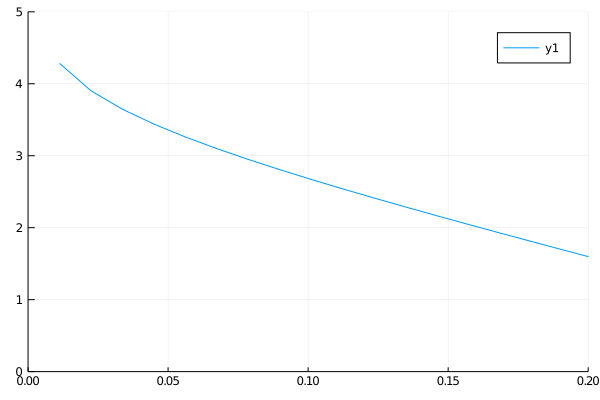

0.75


In [5]:
p1 = plot(sampFsTrue.freqs_f[2:end-1], log10.(sampFsTrue.n_f[2:end-1]))
xlims!(0, 0.2)
ylims!(0, 5)
display(p1)

println(1/(paramsTrue["ρ"]/paramsTrue["ϕ"]+1))

In [6]:
#simulations function for ABC. return distance (sum of squared distances) and solution
function simLV(paramsEst, constants, targetdata)
    p = paramsEst[2]
    t = evolveTime
    λ = mutMean^2 / ((mutVar - mutMean)*(2-p)*t)
    params = Dict(
        # "N"=> paramsTrue["N"],
        "N" => Int(round(paramsEst[1])),
        "ρ" => λ*(1-p),
        "ϕ" => λ*p,
        "μ" => (mutVar-mutMean)/mutMean
    )
    dfs = VAFDyn.DFreqspace(params["N"])
    VAFDyn.evolveVAF(dfs, params, evolveTime)
    sampFs = VAFDyn.sampler(dfs, sampleSize)

    # d = sum(((@view vfs.n_f[2:end-1]) .- reference_f).^2 )
    d = sum(((log10.(sampFs.n_f[2:end-1])) .- reference_f).^2 )
    return d, 1
end

#define ABC setup type
setup = ABCRejection(
    simLV,
    2,
    0.6,
    Prior([DiscreteUniform(100, 2000), Uniform(0.001, 0.999)]),
    maxiterations = 1*10^4,
    nparticles = 100
    )

println("running ABC")
#run ABC SMC algorithm
@time simResult = runabc(setup, reference_f, verbose=true, progress=true, parallel=false)

println("finished ABC")
#show results
show(simResult)

running ABC
Preparing to run in serial on 1 processor


Running ABC rejection algorithm...  4%|█▎                            |  ETA: 6:59:19

InterruptException: InterruptException:

In [10]:
@load "ABC_N-p_Sampled_old.jld2"

3-element Array{Symbol,1}:
 :paramsTrue
 :evolveTime
 :simResult

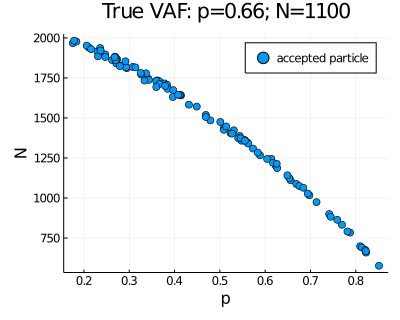

In [35]:
# Plots.scalefontsizes(1.2)
# Plots.resetfontsizes()

param1Accepted_part = []
param2Accepted_part = []

for particle in simResult.particles
    push!(param1Accepted_part, particle.params[1])
    push!(param2Accepted_part, particle.params[2])
end

# h1 = histogram(param1Accepted_part, label="", color=1, bins=20)
# xlabel!("N")
# ylabel!("accepted values")
# h2 = histogram(param2Accepted_part, label="", color=2, bins=20)
# xlabel!("p")
# # ylabel!("accepted values")
# p1 = plot(h1, h2, layout=2)
scale = 0.8

p2 = scatter(param2Accepted_part, param1Accepted_part, label="accepted particle",
#     tickfontsize=12,
#     guidefontsize=14,
    size=(500*scale,400*scale)
    )

xlabel!("p")
ylabel!("N")
title!("True VAF: p=0.66; N=1100")

# p3 = plot(p1, p2, layout=(2,1), size=(600, 800))

# savefig(p3, "ABC_N-p_Sampled.pdf")
savefig(p2, "ABCresult_N-p_Sampled.pdf")

display(p2)

In [8]:
[1,1,1,1,1] ./ [1,2,3,4,5]

5-element Array{Float64,1}:
 1.0
 0.5
 0.3333333333333333
 0.25
 0.2